In [1]:
%matplotlib inline
# notebook to attempt the fingerprinting process before committing it to an actual structure/file

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from Tools.wavehelper import WaveHelper

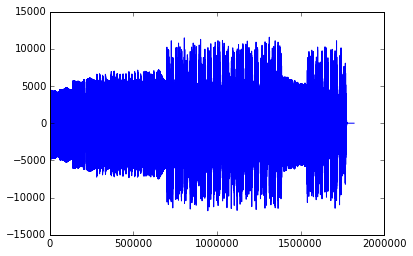

In [2]:
w = WaveHelper("Samples/337653__hmmm101__pixel-song-19.wav")
aud = w.read_whole()
plt.plot(aud)
plt.show()

length of audio: 1818752, length of fft: 1818752


/usr/lib/python3/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


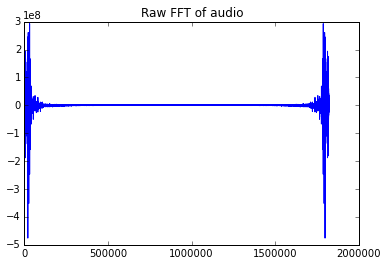

In [3]:
fft_raw = fft(aud)
print("length of audio: {}, length of fft: {}".format(len(aud), len(fft_raw)))
plt.plot(fft_raw)
plt.title("Raw FFT of audio")
plt.show()

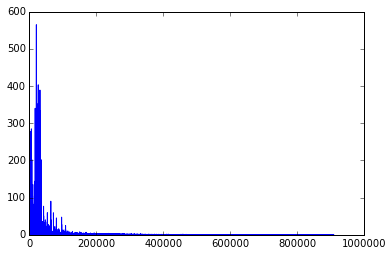

In [4]:
# we need to chop this up until half the values discarding the (imaginary)? part
# the internet says we also need to plot 2/len(arr) * np.abs(arr)
fft_pretty = 2/len(fft_raw) * np.abs(fft_raw[:len(fft_raw)//2])
plt.plot(fft_pretty)
plt.show()

xf: 909376, fft_pretty: 909376


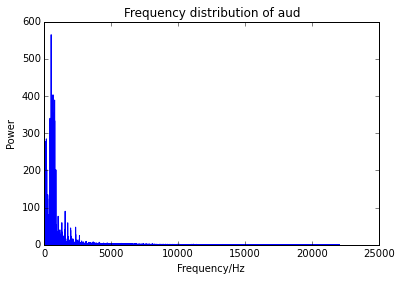

In [5]:
# what concerns me with this plot is that we get "frequencies" up until N/2
# whereas the audio won't have a higher sample rate than 44.1kHz
# ie max recognisable frequency is 22.05kHz
# http://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform says that the above plot
# is just the frequency coefficients and I need to map that to the actual frequency spacing
# freq spacing = fsample / npoints
f_space = w.rate / len(fft_raw)
xf = np.linspace(0, w.rate/2, len(fft_raw)/2) # 3rd argument is number of samples
print("xf: {}, fft_pretty: {}".format(len(xf), len(fft_pretty)))
plt.plot(xf, fft_pretty)
plt.title("Frequency distribution of aud")
plt.ylabel("Power")
plt.xlabel("Frequency/Hz")
plt.show()

do me ugh


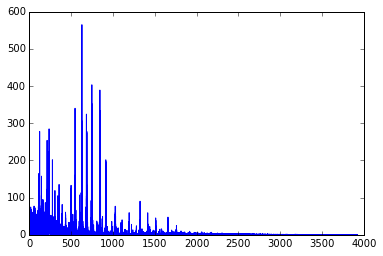

In [6]:
# now we want to get the mel scale representation
# TODO here we should be averaging the y values that round to an integral mel value
print("do me ugh")

def to_mel(iterable):
    """ uses equation from https://en.wikipedia.org/wiki/Mel_scale"""
    return [2595 * np.log10(1 + (i/700)) for i in iterable]

mel = to_mel(xf)
plt.plot(mel, fft_pretty)
plt.show()

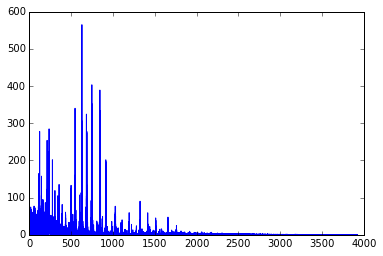

In [7]:
# taking the above, we can define an fft function
def get_frequencies(aud, l_aud, s_rate):
    yf = 2/l_aud * np.abs(fft(aud)[:l_aud//2])
    xf = np.linspace(0, s_rate/2, l_aud/2)
    mel = to_mel(xf)
    return (mel, yf)

# unpacking the tuple into the arguments to plt.plot gets us the same as above
plt.plot(*get_frequencies(aud, len(aud), w.rate))
plt.show()

In [25]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

sgram = []
s_per_n = w.samples_per_n_mili(16)

count = 1
for chunk in chunks(aud, s_per_n):
    sgram.append(get_frequencies(chunk, s_per_n, w.rate))
    print("\rChunk {}".format(count), end='')
    count += 1
print()

# all frequency scales are the same

freq_scales = []
for thing in sgram:
    if not (thing[0] in freq_scales):
        freq_scales.append(thing[0])

print(len(freq_scales))

Chunk 2580
1


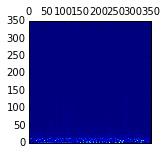

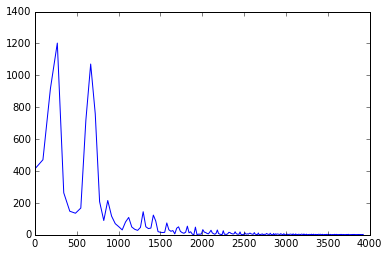

In [27]:
sgram_y = [sg[1] for sg in sgram]
plt.matshow(np.array(sgram_y).T, origin="lower", extent=[0, 350, 0, 350])
plt.show()

plt.plot(sgram[0][0], sgram_y[0])
plt.show()

In [36]:
# generating constellation map
# we need to get points with the largest amplitude
# this should be done per region to aid time invariance aspect
# density criterion should be an adjustable parameter
# how large should the region be? make adj param

density = 0.02 # ie top 2% of points
n_windows = 5
window_l = len(sgram_y[0])

# number of points that each region should have
points_per_chunk = int(window_l * n_windows * density)
print(points_per_chunk, "points per chunk")

count = 0
max_idxs = []
for window in chunks(sgram_y, n_windows):
    # get top points in region
    flat = [item for sublist in window for item in sublist]
    sort = sorted(flat, reverse=True)[:points_per_chunk]
    for item in sort:
        x = count + int(flat.index(item)/window_l)
        y = flat.index(item) % window_l
        max_idxs.append((x, y))
    count += n_windows
print(len(max_idxs), "items, first from first 10 are", max_idxs[:350:points_per_chunk])

35 points per chunk
18060 items, first from first 10 are [(4, 9), (8, 9), (10, 9), (15, 11), (22, 11), (26, 13), (34, 13), (39, 11), (40, 11), (47, 11)]
